In [3]:
%run ../robustness_analysis.ipynb

In [4]:
from lunarlander import LunarLander, INITIAL_RANDOM

In [5]:
# define variables and their bounds
wind_power = [0.0, 20.0]
turbulence_power = [0.0, 2.0]

# define the range of the deviation parameters
dev_bounds = np.asarray([wind_power, turbulence_power])

# define the range of initial force apply to the lander
x0_bounds = np.repeat([[-INITIAL_RANDOM, INITIAL_RANDOM]], 2, axis=0)

# define the deviation parameter value for the original environment (no deviation)
delta_0 = np.asarray([5.0, 0.5])

In [6]:
def env_builder(delta):
    return LunarLander(enable_wind=True, continuous=True, wind_power=delta[0], turbulence_power=delta[1]), x0_bounds

In [10]:
import os
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import SubprocVecEnv, VecMonitor

# Copy the hyperparameters from Stable-baselines3 zoo
# LunarLander-v2:
#   n_envs: 16
#   n_timesteps: !!float 1e6
#   policy: 'MlpPolicy'
#   n_steps: 1024
#   batch_size: 64
#   gae_lambda: 0.98
#   gamma: 0.999
#   n_epochs: 4
#   ent_coef: 0.01

model_name = 'ppo'

if os.path.exists(model_name):
    model = PPO.load(model_name)
else:
    env = VecMonitor(SubprocVecEnv([
        lambda: env_builder(delta_0)[0] for _ in range(12)
    ]))
    model = PPO('MlpPolicy', env, n_steps=1024, batch_size=64, gae_lambda=0.98, gamma=0.999,
                n_epochs=4, ent_coef=0.01, tensorboard_log='./ppo-tensorboard/')
    model.learn(total_timesteps=int(3e6))
    model.save(model_name)

agent = {
    # define the action generation function of the given agent
    'next_action': lambda obs: model.predict(obs, deterministic=True)[0],

    # some agents (like PID) needs to be reset for each run
    'model_reset': None
}

Process ForkServerProcess-16:
Traceback (most recent call last):
  File "/home/cj/miniconda3/envs/rl_robust3.8/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/cj/miniconda3/envs/rl_robust3.8/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/cj/miniconda3/envs/rl_robust3.8/lib/python3.8/site-packages/stable_baselines3/common/vec_env/subproc_vec_env.py", line 27, in _worker
    cmd, data = remote.recv()
  File "/home/cj/miniconda3/envs/rl_robust3.8/lib/python3.8/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_bytes()
  File "/home/cj/miniconda3/envs/rl_robust3.8/lib/python3.8/multiprocessing/connection.py", line 414, in _recv_bytes
    buf = self._recv(4)
  File "/home/cj/miniconda3/envs/rl_robust3.8/lib/python3.8/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
Process ForkServerProcess-22:
Tr

KeyboardInterrupt: 

In [ ]:
# from stable_baselines3.common.evaluation import evaluate_policy

# env = VecMonitor(SubprocVecEnv([
#     lambda: env_builder(delta_0)[0] for _ in range(12)
# ]))
# evaluate_policy(model, env, n_eval_episodes=10)

In [ ]:
obs_space = env_builder(delta_0)[0].observation_space
angle_range = np.asarray([obs_space.low[4], obs_space.high[4]])
x_range = np.asarray([obs_space.low[0], obs_space.high[0]])
y_range = np.asarray([obs_space.low[1], obs_space.high[1]])


def stl_prop():    
    # G ( |angle| < 45 && |x| < 0.6|y| + 0.1 )
    angle = stl.Predicate('angle')
    delta_x = stl.Predicate('delta_x')
    
    angle_threshold = normalize(45 * 2 * np.pi / 360, angle_range)
    
    return stl.Always( (angle < angle_threshold) & (delta_x < 0.1) )
    

def signal_builder(records, time_index):    
    return {
        'angle': stl.Signal(
            normalize(np.abs(records[:, 4]), angle_range),
            time_index
        ),
        'delta_x': stl.Signal(
            normalize(np.abs(records[:, 0]), x_range) - normalize(np.abs(0.6 * records[:, 1]), y_range),
            time_index
        )
    }
    

def episode_eval(obs_record, reward_record):
    return compute_stl_rob(stl_prop(), signal_builder, obs_record)

In [ ]:
# l-2 norm distance
def dist(delta, delta_0):
    delta = normalize(delta, dev_bounds)
    delta_0 = normalize(delta_0, dev_bounds)
    return np.sqrt(np.sum((delta - delta_0) ** 2))

In [ ]:
if not os.path.exists('gifs'):
    os.mkdir('gifs')
if not os.path.exists('data'):
    os.mkdir('data')

In [ ]:
from datetime import datetime

In [8]:
analysis = RobustnessAnalysis(env_builder, agent, episode_eval, delta_0, dev_bounds, dist)
analysis.options['steps_of_each_x0'] = 300
analysis.options['falsification_timeout'] = 1
analysis.options['falsification_num_trials'] = 2
analysis.options['deviation_timeout'] = 20
analysis.options

NameError: name 'agent' is not defined

In [12]:
start = datetime.now()
delta, delta_dist = analysis.any_unsafe_deviation()


================ Any unsafe deviation trial 1 ==============>
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=302603, Tue Nov 22 15:03:26 2022)


Process SpawnPoolWorker-4:
Traceback (most recent call last):
  File "/home/cj/miniconda3/envs/rl_robust/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/cj/miniconda3/envs/rl_robust/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/cj/miniconda3/envs/rl_robust/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/cj/miniconda3/envs/rl_robust/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'LunarLander' on <module '__main__' (built-in)>
Process SpawnPoolWorker-7:
Traceback (most recent call last):
  File "/home/cj/miniconda3/envs/rl_robust/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/cj/miniconda3/envs/rl_robust/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **

KeyboardInterrupt: 

In [ ]:
print('Time to find any unsafe deviation:', datetime.now() - start)
print(delta, delta_dist)

In [ ]:
start = datetime.now()
delta, delta_dist = analysis.min_unsafe_deviation()

In [ ]:
print('Time to find min unsafe deviation:', datetime.now() - start)
print(delta, delta_dist)

In [ ]:
# analysis.visualize_deviation(delta, "gifs/min_counterexample.gif")

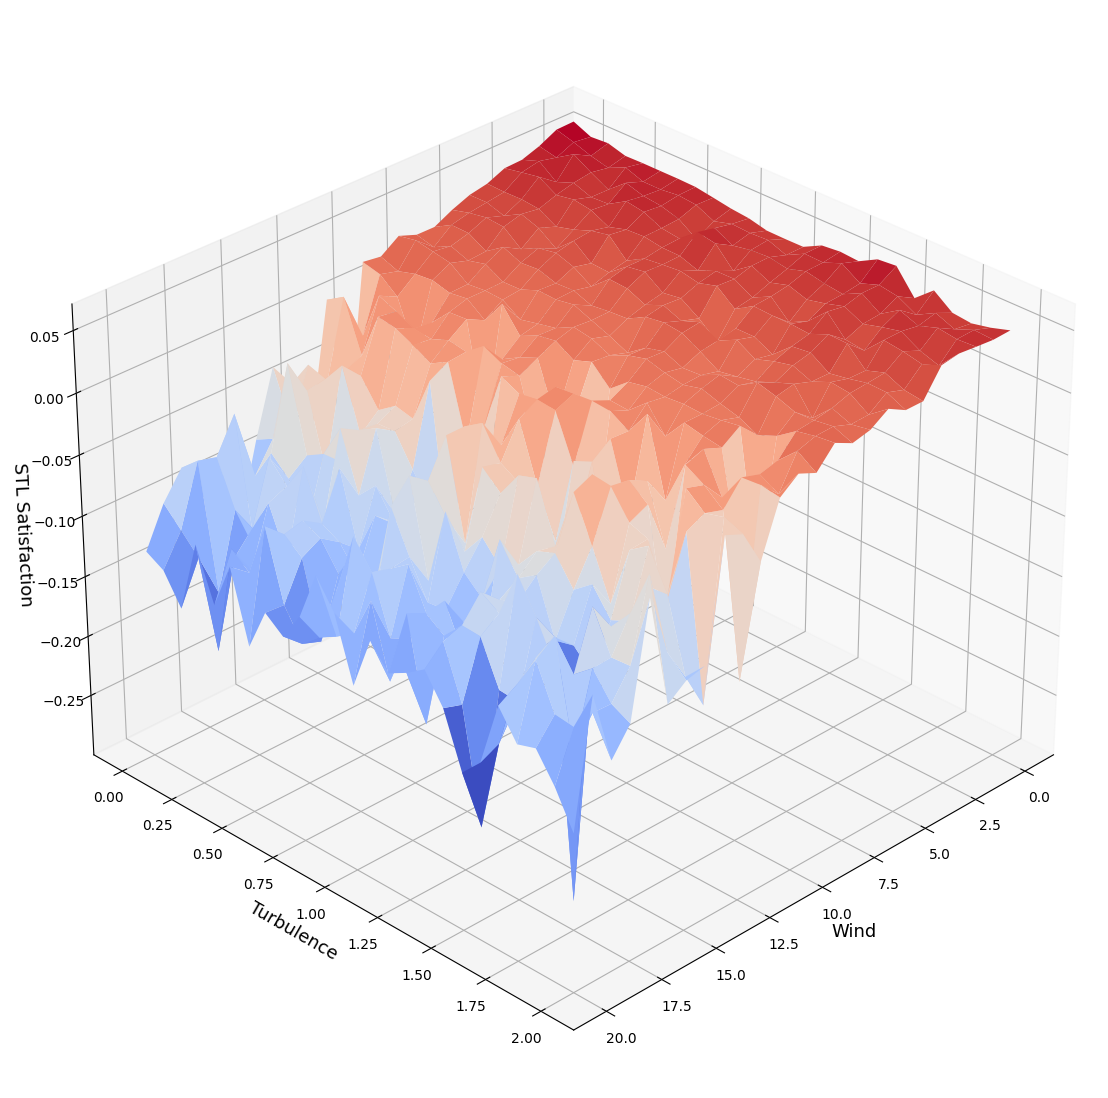

In [14]:
ax, winds, turbulences, grid_data = analysis.grid_plot(wind_power, turbulence_power, 25, 25,
                                                       x_name="Wind", y_name="Turbulence",
                                                       z_name='STL Satisfaction')
ax.view_init(30, 45)
plt.savefig('gifs/robustness-landscape.png', bbox_inches='tight')
plt.show()

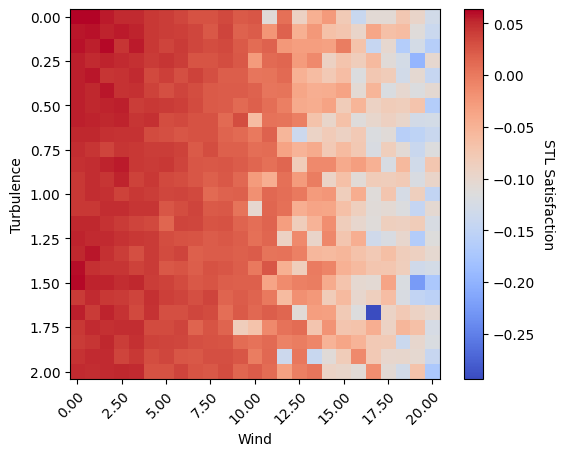

In [15]:
analysis.heatmap(wind_power, turbulence_power, 25, 25, x_name="Wind", y_name="Turbulence",
                 z_name='STL Satisfaction')
plt.savefig('gifs/robustness-landscape-heatmap.png', bbox_inches='tight')
plt.show()

In [ ]:
start = datetime.now()
boundary = analysis.robustness_boundary()

In [ ]:
print(boundary)
print('Time to approximate boundary:', datetime.now() - start)

In [ ]:
ax, winds, turbulences, grid_data = analysis.grid_plot(wind_power, turbulence_power, 25, 25,
                                                       x_name="Wind", y_name="Turbulence",
                                                       z_name='STL Satisfaction', boundary=boundary)
ax.view_init(30, 45)
plt.savefig('gifs/robustness-landscape-boundary.png', bbox_inches='tight')
plt.show()

In [ ]:
analysis.heatmap(wind_power, turbulence_power, 25, 25, x_name="Wind", y_name="Turbulence",
                 z_name='STL Satisfaction', boundary=boundary)
plt.savefig('gifs/robustness-landscape-boundary-heatmap.png', bbox_inches='tight')
plt.show()

In [12]:
def episode_eval_reward(obs_record, reward_record):
    return reward_record.sum()

In [13]:
analysis_reward = RobustnessAnalysis(env_builder, agent, episode_eval_reward, delta_0, dev_bounds, dist)
analysis_reward.options['steps_of_each_x0'] = 300
analysis_reward.options['falsification_timeout'] = 1
analysis_reward.options['falsification_num_trials'] = 2
analysis_reward.options['deviation_timeout'] = 20
analysis_reward.options

{'epsilon': 0.01,
 'deviation_num_trials': 3,
 'deviation_sigma': 0.2,
 'deviation_timeout': 20,
 'falsification_sigma': 0.2,
 'falsification_timeout': 1,
 'falsification_num_trials': 2,
 'falsification_episodes': 100,
 'episodes_of_each_x0': 1,
 'steps_of_each_x0': 300}

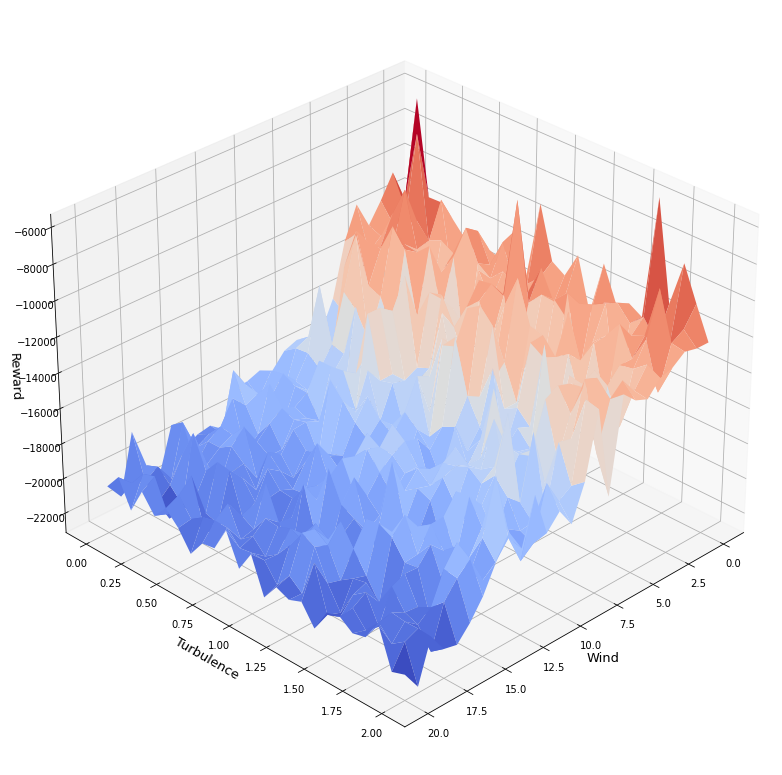

In [14]:
ax, winds, turbulences, grid_data = analysis_reward.grid_plot(wind_power, turbulence_power, 25, 25,
                                                              out_dir='data_reward',
                                                              x_name="Wind", y_name="Turbulence",
                                                              z_name='Reward')
ax.view_init(30, 45)
plt.savefig('gifs/robustness-landscape-reward.png')
plt.show()